In [1]:
# import the required libraries
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [2]:
# read the dataset
file_path = os.path.join('data', 'NYCTaxiFares.csv')
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [4]:
df

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1
...,...,...,...,...,...,...,...,...
119995,2010-04-18 14:33:03 UTC,15.3,1,-73.955857,40.784590,-73.981941,40.736789,1
119996,2010-04-23 10:27:48 UTC,15.3,1,-73.996329,40.772727,-74.049890,40.740413,1
119997,2010-04-18 18:50:40 UTC,12.5,1,-73.988574,40.749772,-74.011541,40.707799,3
119998,2010-04-13 08:14:44 UTC,4.9,0,-74.004449,40.724529,-73.992697,40.730765,1


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,120000.0,10.040326,7.500134,2.500000,5.700000,7.700000,11.30000,49.900000
fare_class,120000.0,0.333333,0.471406,0.000000,0.000000,0.000000,1.00000,1.000000
pickup_longitude,120000.0,-73.976626,0.031497,-74.465447,-73.992386,-73.982084,-73.96871,-73.311845
pickup_latitude,120000.0,40.751443,0.025821,40.121653,40.736594,40.753661,40.76802,40.981292
dropoff_longitude,120000.0,-73.974501,0.032419,-74.443323,-73.991478,-73.980411,-73.96550,-73.496140
dropoff_latitude,120000.0,40.751695,0.030279,40.164927,40.735914,40.754441,40.76888,40.993498
passenger_count,120000.0,1.347167,0.759263,1.000000,1.000000,1.000000,1.00000,5.000000


In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the distance between 2 points.
    
    This function calculates the haversine distance between 2 sets of GPS coordinates. Find the details in
    https://en.wikipedia.org/wiki/Haversine_formula
    
    Parameters:
    df (pandas.DataFrame): The dataframe including the GPS coordinates
  
    Returns:
    pandas.Series: The distance of all points in kilometers

    
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [7]:
#we add a column for storing the trip distances
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [8]:
# We breakdown the pickup time to fine grained details which will is of importance for the model
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
# we devide the columns to categorical, continious and label columns
categorical_columns = ['Hour', 'AMorPM', 'Weekday']

continious_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

y_column = ['fare_amount']

In [11]:
# Convert our three categorical columns to category dtypes
for category in categorical_columns:
    df[category] = df[category].astype('category')

df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [12]:
hour = df['Hour'].cat.codes.values
am_pm = df['AMorPM'].cat.codes.values
week_day = df['Weekday'].cat.codes.values

categories = np.stack([hour, am_pm, week_day], 1)

In [13]:
# Convert categorical variables to a tensor
categories = torch.tensor(categories, dtype=torch.int64) 

In [14]:
# Convert continuous variables to a tensor
continiouses = np.stack([df[columns].values for columns in continious_columns], 1)
continiouses = torch.tensor(continiouses, dtype=torch.float)

In [15]:
# Convert labels to a tensor
y = torch.tensor(df[y_column].values, dtype=torch.float).reshape(-1,1)

In [16]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
categories_sizes = [len(df[column].cat.categories) for column in categorical_columns]
embedding_sizes = [(size, min(50, (size+1)//2)) for size in categories_sizes]

In [17]:
class TabularModel(nn.Module):

    def __init__(self, embedding_sizes, continious_no, out_size, layers, probability=0.5):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(size_of_category, size_of_embed) for size_of_category,size_of_embed in embedding_sizes])
        self.embedding_drop = nn.Dropout(probability)
        self.continious_normalization = nn.BatchNorm1d(continious_no)
        
        layer_list = []
        embedding_no = sum((size_of_embed for size_of_category,size_of_embed in embedding_sizes))
        input_no = embedding_no + continious_no
        
        for layer_width in layers:
            layer_list.append(nn.Linear(input_no,layer_width)) 
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(layer_width))
            layer_list.append(nn.Dropout(probability))
            input_no = layer_width
        layer_list.append(nn.Linear(layers[-1],out_size))
            
        self.layers = nn.Sequential(*layer_list)
    
    def forward(self, x_categorical, x_continious):
        embeddings_list = []
        for i,e in enumerate(self.embeddings):
            embeddings_list.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings_list, 1)
        x = self.embedding_drop(x)
        
        x_continious = self.continious_normalization(x_continious)
        x = torch.cat([x, x_continious], 1)
        x = self.layers(x)
        return x

In [18]:
torch.manual_seed(42)
model = TabularModel(embedding_sizes, continiouses.shape[1], 1, [200,100], probability=0.4)

In [19]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
batch_size = 1000 #the amount of samples is len(df)=120,000 but just for the sake of running faster here I used this
test_size = int(batch_size * .2)

categories_train = categories[:batch_size-test_size]
categories_test = categories[batch_size-test_size:batch_size]
continiouses_train = continiouses[:batch_size-test_size]
continiouses_test = continiouses[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [21]:
#train the model
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_prediction = model(categories_train, continiouses_train)
    loss = torch.sqrt(criterion(y_prediction, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.35908699
epoch:  26  loss: 10.67487621
epoch:  51  loss: 9.75207806
epoch:  76  loss: 9.19721127
epoch: 101  loss: 8.63146400
epoch: 126  loss: 7.94379473
epoch: 151  loss: 7.04895735
epoch: 176  loss: 5.89843464
epoch: 201  loss: 4.62885380
epoch: 226  loss: 3.80666351
epoch: 251  loss: 3.28142071
epoch: 276  loss: 3.11033678
epoch: 300  loss: 2.94236946

Duration: 2 seconds


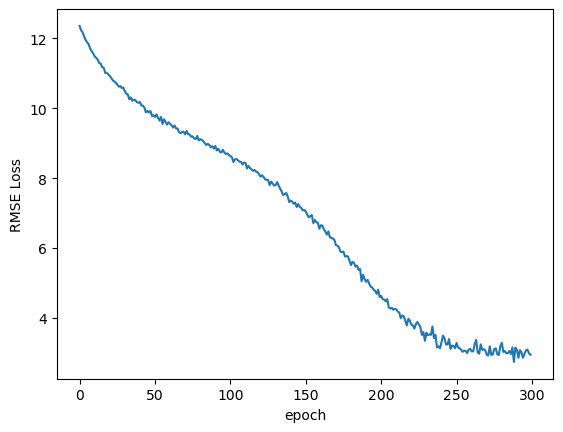

In [22]:
#plot the loss function
with torch.no_grad():
    plt.plot(range(epochs), losses)
    plt.ylabel('RMSE Loss')
    plt.xlabel('epoch');

In [23]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_validation = model(categories_test, continiouses_test)
    loss = torch.sqrt(criterion(y_validation, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.57493377
